<a href="https://colab.research.google.com/github/cutlersimpson/GU-ML/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
#import pandas and numpy
import pandas as pd
import numpy as np

#PCA
from sklearn.decomposition import PCA 

#import standard classification tools from sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import itertools

#classification model
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

template = 'ggplot2'

In [114]:
# Read in data
data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_RSEM_42cases.txt', sep='\t', header=(0))
annotation_data = pd.read_csv('https://github.com/PineBiotech/omicslogic/blob/master/TCGA_43_clinical.csv?raw=true', index_col=None)

# Change annotation_data naming to match with data naming
annotation_data['Variable'] = annotation_data['Variable'].str.replace('-', '_')
annotation_data['Variable'] = annotation_data['Variable'].str[:16]
stage = annotation_data[["Variable", "pathologic_stage"]]

features = data.iloc[1:, 0].values

data=data.drop(['ID'], axis = 1) 
dataT = np.transpose(data)

# Merge dataframes so stage is mapped to other data
all_data = stage.merge(dataT, how='inner', left_on='Variable', right_on=dataT.index.values)
all_data = all_data[all_data.pathologic_stage != '[Not Available]']
all_data['pathologic_stage'] = np.where(all_data['pathologic_stage'] == 'Stage I', 'Early', all_data['pathologic_stage'])
all_data['pathologic_stage'] = np.where(all_data['pathologic_stage'] == 'Stage II', 'Early', all_data['pathologic_stage'])
all_data['pathologic_stage'] = np.where(all_data['pathologic_stage'] != 'Early', 'Late', all_data['pathologic_stage'])

#save numeric data separate from labels (X = numeric matrix, y=labels)
X = all_data.iloc[:, 2:].values
y = all_data.iloc[:, 1].values

#save class names
classes = np.unique(y)
n_classes = len(classes)

all_data.pathologic_stage.value_counts()

Early    24
Late     11
Name: pathologic_stage, dtype: int64

To ensure there are enough data points from each stage being investigated, the stages are categorized to either early or late where early stage is Stage I and Stage II while late consists of the remaining stages. This allows us to stratify the test data where as before there was only one sample for Stage IV and Stage IIIB so there were not enough points for stratification. Furthermore, the samples that do not have stage data available, that is those with stage 'not available' are dropped from the analysis.

In [115]:
# Create test and train datasets
X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=1, stratify=y)

#print out test class proportion from total
for i in range(len(classes)):
  print(classes[i], y_test.tolist().count(classes[i]), "/", y.tolist().count(classes[i]))

Early 17 / 24
Late 8 / 11


In [116]:
cat = all_data['pathologic_stage']
dataT = all_data.iloc[: ,2:]
dataT.head()

,0,1,2,3,4,5,6,7,8,9,...,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530
2,0.00,1.33,3.67,225.54,2202.00,0.00,62.00,0.00,0.00,0.00,...,100.00,1299.00,1880.00,62.00,3382.00,4889.00,1105.00,1150.00,14.00,99.00
3,0.00,14.61,9.39,180.51,1499.00,0.00,100.00,1.00,0.00,0.00,...,57.00,695.00,2112.00,66.00,3540.00,1616.00,1680.00,1589.00,18.00,363.00
4,0.00,48.06,67.94,303.27,1572.00,0.00,725.00,0.00,0.00,0.00,...,88.00,4385.00,2169.00,18.00,1175.00,6540.00,1542.00,1768.00,2.00,4.00
6,1.04,3.58,4.42,231.89,2937.00,0.00,484.00,0.00,1.00,0.00,...,46.00,1461.00,3919.00,85.00,2594.00,3327.00,1716.00,1969.00,33.00,198.00
8,0.00,0.00,0.00,224.42,1937.00,0.00,54.00,1.00,10.00,0.00,...,45.00,1196.00,1497.00,15.00,1390.00,9525.00,1024.00,988.00,7.00,137.00


In [117]:
#Run Principal Component Analysis
pca = PCA(n_components=3) 

pca.fit(dataT) 
xpca = pca.transform(dataT)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Pathologic Stage", color=cat,
                       template="plotly_white", height=800, width=800)
figPCA.show()

There is no clear distinguishing plane between the early and late stage samples so there may still be difficultly in classifying the data.

In [118]:
# Support Vector Classification Model

warnings.filterwarnings('ignore') 

# C - Regularization parameter. The strength of the regularization.
model = LinearSVC(C = 1.0)
model.fit(X_train, y_train)

LinearSVC()

In [119]:
# Check accuracy of model
predictions = model.predict(X_test)

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

model_accuracy

0.6

Using feature selection to remove unavailable data points and categorizing the samples into early and late stage rather than relying on the initial deeper stage breakdown has increased the model accuracy from near 15% to almost 60%. This is still not where we want it to be but it is significantly improved.

In [120]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [121]:
# Confusion Matrix of data

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

heat = go.Heatmap(z = CM_df, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

# The low accuracy score and confusion matrix demonstrate this model did not perform well

In [122]:
# Find top features
top_features_count = 20

# we use median of weights from all classes, you can also use np.sum(np.abs(model.coef_, axis=0))
vector_weights = np.median(model.coef_, axis=0)
top_positive_coefficients = np.argsort(vector_weights)[-top_features_count:]
top_negative_coefficients = np.argsort(vector_weights)[:top_features_count]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features, top_features_weights = features[top_coefficients], vector_weights[top_coefficients]

d = {'Features':features[top_coefficients], 'Weight':vector_weights[top_coefficients]}
df_features = pd.DataFrame(d)

#plot feature significance
fig = px.bar(y=df_features.Features, x=df_features.Weight, template=template)
fig.update_layout(width=700, height=1000, template=template, title="Feature Significance")
fig.show()

In [123]:
# Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=500, bootstrap=True)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [124]:
# Check Random Forest accuracy

predictions = model.predict(X_test)
c_matrix = confusion_matrix(y_test,predictions)

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

model_accuracy

0.56

The Random Forest classification has gone from 20% to 55.5% by making these changes. Interestingly, random forest led to higher accuracy with the initial dataset but is now not performing as well.

In [125]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [126]:
heat = go.Heatmap(z = c_matrix, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

In [127]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances[:-1], index=features)

RF_df = pd.DataFrame(forest_importances.sort_values(ascending=False))
RF_df.columns = ['Feature']

#plot feature significance
fig = px.bar(RF_df[0:20], template=template)
fig.update_layout(width=1000, height=700, template=template, title="Top 20 Features by Significance")
fig.show()

In [128]:
!pip uninstall scikit-learn -y -q
!pip install scikit-learn==0.24 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.


In [129]:
warnings.filterwarnings('ignore')

!pip install lazypredict -q

In [130]:
import time 
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier,LazyRegressor

#Create a lazyClassifier model
model=LazyClassifier(verbose=0,predictions=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

# fit and train the model 
start_time_1=time.time()
models_c,predictions_c=model.fit(X_train, X_test, y_train, y_test)
end_time_1=time.time()

100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


In [131]:
fig = px.bar(models_c[['Time Taken', 'F1 Score','Accuracy']], barmode='group', template=template)
fig.update_layout(width=1200, height=700, template=template, title="Classification Report")
fig.show()

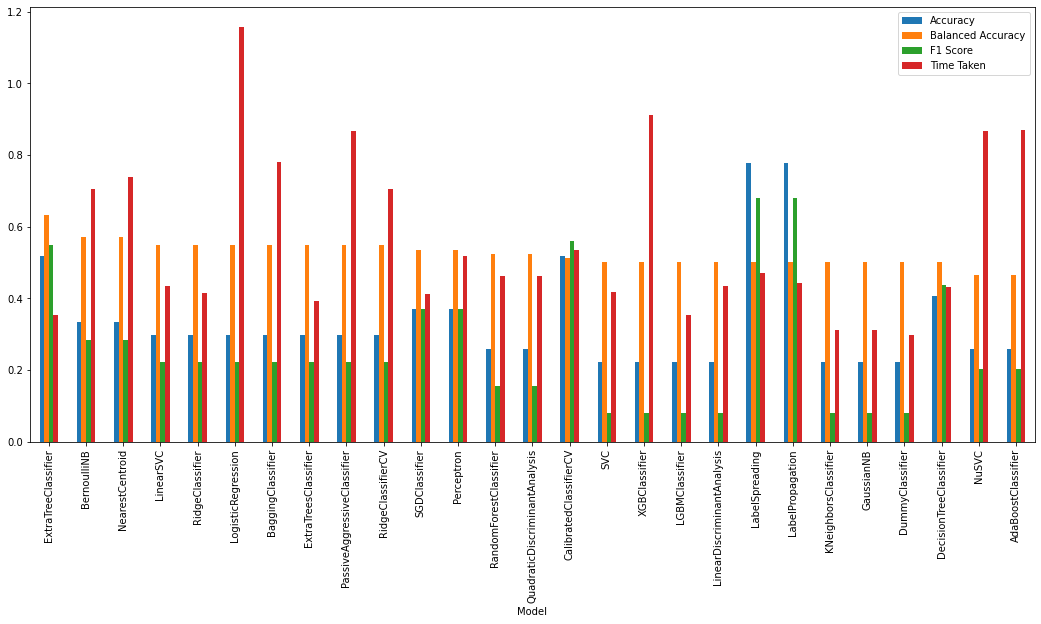

In [132]:
models_c.plot.bar(figsize = (18,8));

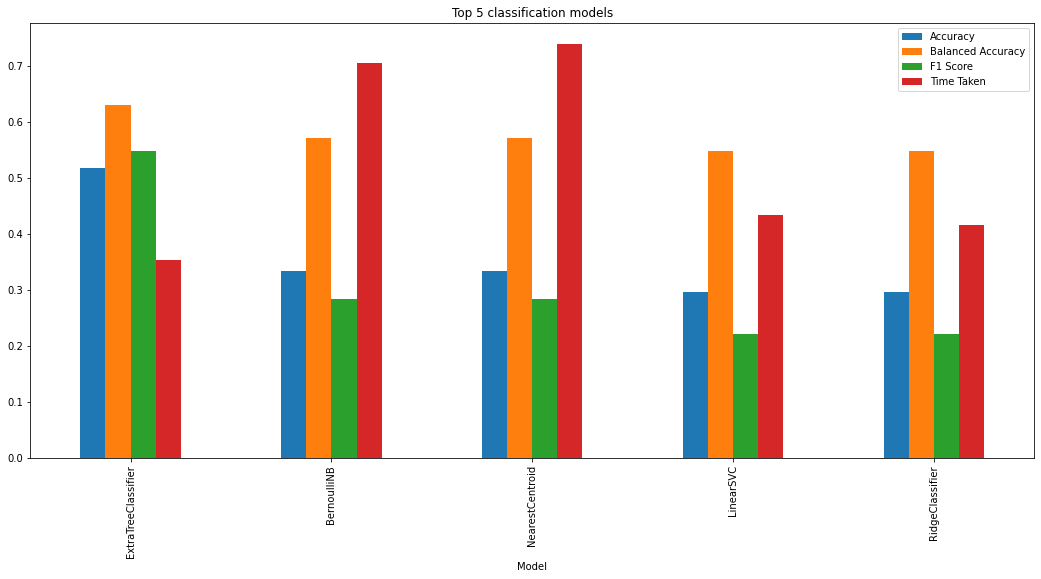

In [133]:
models_c.iloc[0:5].plot.bar(figsize = (18,8), title="Top 5 classification models");

# Discussion
---
<br />

To begin analyzing the LIHC risk factor dataset from The Cancer Genome Atlas, the data and the corresponding annotated data were read into separate Pandas dataframes. With this data read in, it became obvious that the naming conventions were different between the datasets so the annotation data was manipulated so that the variable names matched with those in the LIHC data. With these names now consistent, the data frames were merged into a single data frame and processed to separate out the numeric values from the pathologic stages and create train and test data sets using the sklearn train_test_split function. The original dataset contained 42 samples so the test_size parameter in this function was set to 0.75 because smaller values led to not enough data from each of the 7 pathologic stage (Stage I, Stage II, Stage III, Stage IIIA, Stage IIIC, Stage IV, and Not Available) being present in the test data, therefore the confusion matrix was failing to be produced due to mismatched array sizes.

With the test and train data splits, these values were first fed to a linear SVC model that had a poor model accuracy of 15.6%. Upon looking at the reduced dimensionality PCA plot for the data, there was no clear distinction among the pathologic stages and only 27.92% of the variance was explained by 2 principal components. The confusion matrix and classification report of this model showed the Stage II data performed best in this linear model with 2 of the 5 samples accurately being classified as Stage II.

After the poor linear SVC results, a random forest model was applied to the data with n_estimators (i.e. the number of trees in the forest) set to 500. This resulted in a model with a 28.1% accuracy, significantly outperforming the linear model but still not serving as a good representation of the data. In fact, the only samples that were classified correctly at all were the 9 Stage I samples out of the total 13 in the test data.

After analyzing both the linear SVC model and random forest, the most significant features were plotted for both models. The linear model yielded C4A720, CLVS1157807, SERPINA312, APOF319, and AHCTF125909 as significant features with the highest value being 0.006 while the random forest model produced LOH12CR1118426, DSCR410281, RAB369609, FBLN7129804, and ARIH210425 as significant and 0.0035 as the highest value. Because there was no overlap in significant features between these models and neither one accurately classified the data, marker genes to explore further can be taken from both groups such as C4A720, CLVS1157807, and SERPINA312 from the linear model and LOH12CR1118426 and DSCR410281 from the random forest.

The final model tested with the data was the Lazy Classifier to test multiple models simultaneously then plotted against one another with time, F1 scores, and accuracy included to compare results. The top 5 classification models per the Lazy Classifier were Linear SVC, XGB Classifier, Nearest Centroid, Random Forest, and Label Propagation. Of these, the best F1 score was in the Label Propagation model and the fastest model was the Random Forest. Despite the speed increase from the Random Forest model, the Label Propagation F1 scores demonstrated a better fit for the data, and given the poor results of all models, would be worth exploring further.

---

## Feature Selection Update
Feature selection was performed by initially eliminating data points that did not have a pathologic stage associated with them. This step alone helped to remove 7 data points that were noise in the initial analysis. After this, to reduce the number of classifications the model was trying to fit, the data was categorized as either early stage or late stage where early stage meant Stage I or Stage II and the remaining samples were late stage. Making this change improved the SVC model accuracy from 15.6% to 51%. To further improve this model, when the train test split was created, the data was straified on the early/ late categorization. With this improvement, the SVC accuracy jumped to 59.3% which is a significant improvement from the initial less than 16% accuracy. One further step taken to slightly improve the SVC accuracy was reducing the test split from 0.75 to 0.7 which pushed the accuracy to 60%, however this jumps back down to 52% when the split is reduced further to 0.65.

With this categorization in place, an initial PCA analysis with 3 components was conducted. However, despite reducing the number of stages of interest, there was still no clear grouping or separation in the reduced dimension space. Yet, there was a large increase in the variance explained. The initial 2 component PCA explained 27.92% of the variance in the data and the updated 3 component PCA explains 68.85% of the variance, approaching the acceptable threshhold of 80% variance explained.

The most noticable change occured when updating the LazyPredict models for the data. Initially, each of the top 5 models from this classifier had poor accuracy and F1 scores, but the updated top 5 models (Extra Tree Classifier, Bernoulli NB, Nearest Centroid, Linear SVC, and Ridge Classifier) all have F1 scores over 25% which was higher than the highest Label Propagation score initially. The new best model in terms of accuracy, F1 score, and balanced accuracy is the Extra Tree Classifier and the new fastest model is the Ridge Classifier. Just these small changes significantly improved the results including accuracy, F1 score, and variance explained in the reduced dimensionality PCA space.